# Bicycle Crash analysis NEISS data 1999 to 2018
## National Electronic Injury Surveillance System

https://github.com/mrcorbett/MET_CS677_DataScienceWithPython/tree/master


"CPSC’s National Electronic Injury Surveillance System (NEISS) is a national probability sample of hospitals in the U.S. and its territories. Patient information is collected from each NEISS hospital for every emergency visit involving an injury associated with consumer products."

https://catalog.data.gov/dataset/cpscs-national-electronic-injury-surveillance-system-neiss
https://www.cpsc.gov/cgibin/NEISSQuery/home.aspx



In [1]:
# Imports

import calendar
from code_id_translator import *
from datetime import datetime
import graphviz
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact, fixed
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
from neiss_backend import *
import numpy as np
import os
import pandas as pd
import pickle
import re
from scipy.stats import chi2_contingency
from scipy.stats import chi2
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2, f_regression, mutual_info_regression
from sklearn.feature_selection import SelectPercentile, SelectFpr, SelectFdr, SelectFwe, GenericUnivariateSelect
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, scorer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz, plot_tree
import seaborn as sns
import sys
from time_based_graphs import *
import xlrd

#from sklearn import datasets


In [2]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')

In [3]:
class Includes():
    TimeBasedGraphs = True
    PearsonChiSquared = True
    PythonCorr = True
    LinearRegressionChi2 = True
    LogisticRegression = True
    GaussianNB = True
    DecisionTree = True


- Selection of geographic areas called primary sampling units (PSU) that are defined within sampling strata. 

https://www.cdc.gov/nchs/nhis/singleton_psu.htm

## Read the pickled neissYYYY.xlsx file

convert_neiss_original_data_to_pckl.ipynb is used to create the pickled file

In [4]:
neiss_pathname = os.getcwd() + '/data/NEISS'

pckl_fname = neiss_pathname + '/neiss_data.pckl'
if os.path.exists(pckl_fname):
    print("Reading {}  ... ".format(pckl_fname), end="")
    dfNeiss = pickle.load( open( pckl_fname, "rb" ) )
    print("done!")
else:
    raise Exception(
        'ERROR:  {} does not exist\n  Use "convert_neiss_original_data_to_pckl.ipynb" to create the pckl file'.format(
            pckl_fname))


Reading /Users/mcorbett/Boston University/MET_CS677_DataScienceWithPython/Project/data/NEISS/neiss_data.pckl  ... done!


In [5]:
dfNeiss.shape

(7352927, 19)

In [6]:
dfNeiss.head()

,CPSC_Case_Number,Treatment_Date,Age,Sex,Race,Other_Race,Body_Part,Diagnosis,Other_Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Product_2,Narrative_1,Narrative_2,Stratum,PSU,Weight
0,100001,1999-12-24,41,2,1.0,0,31,71,NaN,1,0,0,3299,0,41 YR FEMALE FELL WHILE WALKING. DX: SEVERE MU...,/RIGHT BUTTOCKS & BACK.,S,71,68.1086
1,100002,1999-12-27,80,1,2.0,0,31,57,NaN,1,0,0,611,0,80 YR MALE FELL IN BATHROOM/HE HIT RIGHT RIBS ...,DX: FRACTURED RIGHT RIBS-UPPER TRUNK,S,71,68.1086
2,100003,1999-12-27,4,1,1.0,0,75,53,NaN,1,0,0,1328,0,4 YR MALE HAD METAL LARGE WAGON WHEEL FALL & H...,DX: CONTUSIN ON HEAD/NO LOC.,S,71,68.1086
3,100005,1999-12-28,18,1,0.0,NaN,94,53,NaN,1,0,0,1205,0,CONTUSION EAR - STRUCK IN RIGHT EAR WITH BASKE...,NaN,S,7,68.1086
4,100009,1999-12-28,19,2,0.0,NaN,92,64,NaN,1,0,0,5031,0,SPRAIN THUMB - INJURED THUMB WHEN SNOWBOARDING,NaN,S,7,68.1086


### Update Neiss with column code dictionary from Excel file

In [7]:
column_codes_fname = neiss_pathname + '/column_codes.xlsx'
column_dictionary = getColumnCodeDictionary(column_codes_fname)
Neiss.setColumnCodeDictionary(column_dictionary)

- Code to take the Neiss dictionaries for column codes and write them out to the column_codes.xlsx file.

In [8]:
neiss = Neiss(dfNeiss)

In [9]:
dfNeiss.shape

(7352927, 19)

## Build a categorical dataframe (with a subset of the overall data 3000 random rows)

The dataframe is built of columns that are only categorical in nature.

In [10]:
class NeissSubset():
    def __init__(self, df, categories):
        self.df = df.copy()
        self.categories = categories.copy()

        self.df = self.df.xs(self.categories, axis=1)
        self.df.dropna(inplace=True)
        self.df['Race'] = [int(x) for x in self.df['Race']]
        #self.updateCodeIdVariables()

    def updateCodeIdVariables(self):
        # Get the code ID translator for the dataframe
        self.codeIdTranslator = CodeIdTranslatorDataFrame(self.df, self.categories)
        self.codeIdTranslator.transformColumns()

        # Get the code ID translators for the dataframe
        currentState = self.codeIdTranslator.getState()

        self.codeIdTranslator.setState('id')
        self.dfIdToCode = self.codeIdTranslator.getDataFrame().copy()

        self.codeIdTranslator.setState('code')
        self.dfCodeToId = self.codeIdTranslator.getDataFrame().copy()

        self.codeIdTranslator.setState(currentState)

    def limitColumnCategoriesTo(self, column_name, num_categories):
        '''
         Get the top 'num_categories' most frequent names in self.df[column_name]
         
         Args:
             column_name (str):  The name of the column to limit the categories on
             num_categories (int):  The maximum number of unique values to retain in 'column_name'
        '''
        selected = self.df[column_name].value_counts()[:num_categories].index.tolist()
        self.df = self.df[self.df[column_name].isin(selected)]
        #self.updateCodeIdVariables()

    def limitMaxRowsTo(self, num_rows):
        self.df = self.df.sample(num_rows)
        #self.updateCodeIdVariables()

    def getDataframe(self):
        return self.df

    def getCategories(self):
        return self.categories
    
    def getCodeIdTranslator(self):
        return self.codeIdTranslator
    
    def getIdToCodeDataframe(self):
        return self.dfIdToCode
    
    def getCodeToIdDataframe(self):
        return self.dfCodeToId

In [11]:
neissSubset = NeissSubset(dfNeiss,
    categories=['Sex', 'Race', 'Body_Part', 'Diagnosis', 'Disposition', 'Location',
    'Fire_Involvement', 'Product_1', 'Product_2', 'PSU', 'Stratum' ])

In [12]:
output_choice = 'Diagnosis'
neissSubset.limitColumnCategoriesTo(output_choice, 10)

In [13]:
neissSubset.limitMaxRowsTo(100000)
neissSubset.getDataframe().shape

(100000, 11)

In [14]:
neissSubset.updateCodeIdVariables()

In [15]:
neissSubset.getCategories()

['Sex',
 'Race',
 'Body_Part',
 'Diagnosis',
 'Disposition',
 'Location',
 'Fire_Involvement',
 'Product_1',
 'Product_2',
 'PSU',
 'Stratum']

In [16]:
neissSubset.getDataframe().head()

,Sex,Race,Body_Part,Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Product_2,PSU,Stratum
353629,3,1,16,5,1,2,1,521,1,69,2
2485,3,3,13,9,1,2,1,521,1,100,3
5812,3,3,23,10,1,1,1,134,1,25,5
347027,2,2,23,10,1,2,1,317,1,46,4
226782,2,1,24,5,1,2,1,658,1,67,5


In [17]:
neissSubset.getCodeIdTranslator().getTranslator()

translator
Function Category                                                           
codeToId Body_Part         [{30: 1, 31: 2, 32: 3, 33: 4, 34: 5, 35: 6, 36...
         Diagnosis         [{52: 1, 53: 2, 55: 3, 56: 4, 57: 5, 59: 6, 62...
         Disposition            [{1: 1, 2: 2, 4: 3, 5: 4, 6: 5, 8: 6, 9: 7}]
         Fire_Involvement                   [{0: 1, 1: 2, 2: 3, 3: 4, 4: 5}]
         Location          [{0: 1, 1: 2, 2: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8:...
         PSU               [{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8:...
         Product_1         [{102: 1, 110: 2, 112: 3, 114: 4, 115: 5, 116:...
         Product_2         [{0: 1, 110: 2, 112: 3, 113: 4, 114: 5, 115: 6...
         Race                   [{0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 5: 6, 6: 7}]
         Sex                                            [{0: 1, 1: 2, 2: 3}]
         Stratum                  [{'C': 1, 'L': 2, 'M': 3, 'S': 4, 'V': 5}]
idToCode Body_Part         [{1: 30, 2: 31, 3: 32, 4: 33, 5: 34, 6: 35, 7:...
         Diagnosis         [{1: 52, 2: 53, 3: 55, 4: 56, 5: 57, 6: 59, 7:...
         Disposition            [{1: 1, 2: 2, 3: 4, 4: 5, 5: 6, 6: 8, 7: 9}]
         Fire_Involvement                   [{1: 0, 2: 1, 3: 2, 4: 3, 5: 4}]
         Location          [{1: 0, 2: 1, 3: 2, 4: 4, 5: 5, 6: 6, 7: 7, 8:...
         PSU               [{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8:...
         Product_1         [{1: 102, 2: 110, 3: 112, 4: 114, 5: 115, 6: 1...
         Product_2         [{1: 0, 2: 110, 3: 112, 4: 113, 5: 114, 6: 115...
         Race                   [{1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}]
         Sex                                            [{1: 0, 2: 1, 3: 2}]
         Stratum                  [{1: 'C', 2: 'L', 3: 'M', 4: 'S', 5: 'V'}]

## Show the IdToCode and CodeToId translators for the neissSubset dataframe

In [18]:
neissSubset.getIdToCodeDataframe().head()

,Sex,Race,Body_Part,Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Product_2,PSU,Stratum
353629,3,1,16,5,1,2,1,521,1,69,2
2485,3,3,13,9,1,2,1,521,1,100,3
5812,3,3,23,10,1,1,1,134,1,25,5
347027,2,2,23,10,1,2,1,317,1,46,4
226782,2,1,24,5,1,2,1,658,1,67,5


In [ ]:

neissSubset.getCodeToIdDataframe().head()

,Sex,Race,Body_Part,Diagnosis,Disposition,Location,Fire_Involvement,Product_1,Product_2,PSU,Stratum
353629,2,0,82,57,1,1,0,1807,0,69,L
2485,2,2,79,64,1,1,0,1807,0,100,M
5812,2,2,92,71,1,0,0,604,0,25,V
347027,1,1,92,71,1,1,0,1233,0,46,S
226782,1,0,93,57,1,1,0,4056,0,67,V


## Show time based graphs of male/female injuries - whole dataframe used

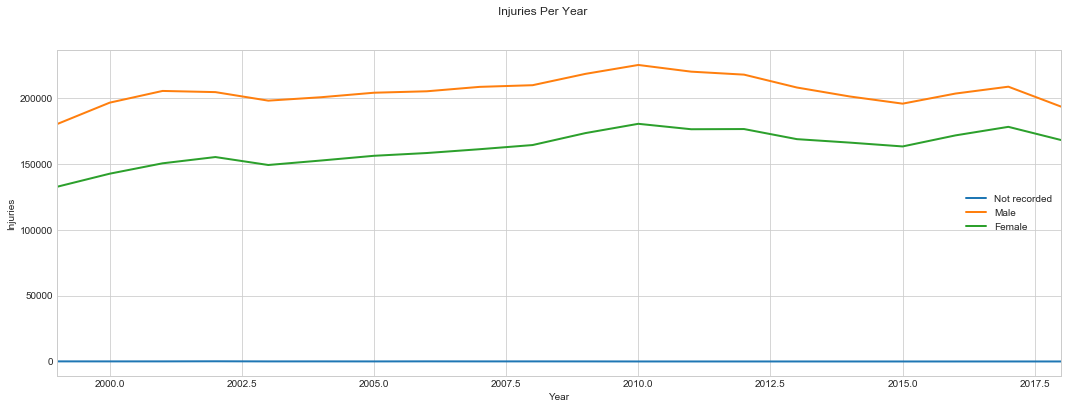

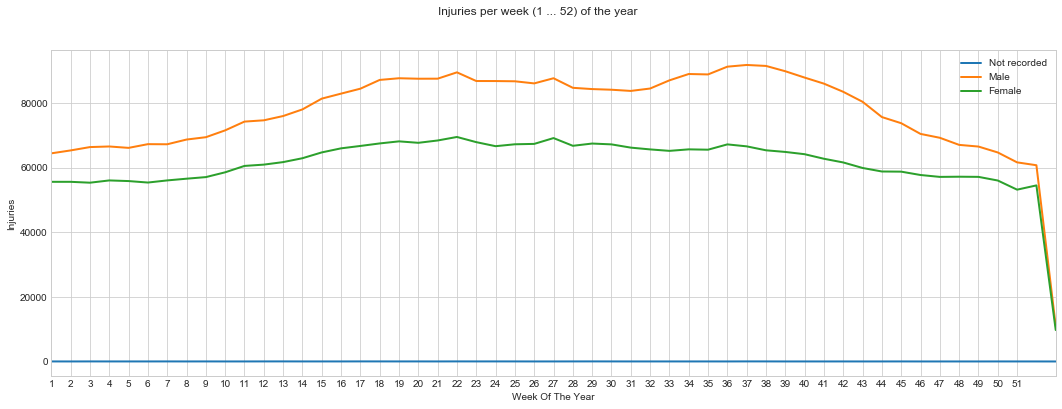

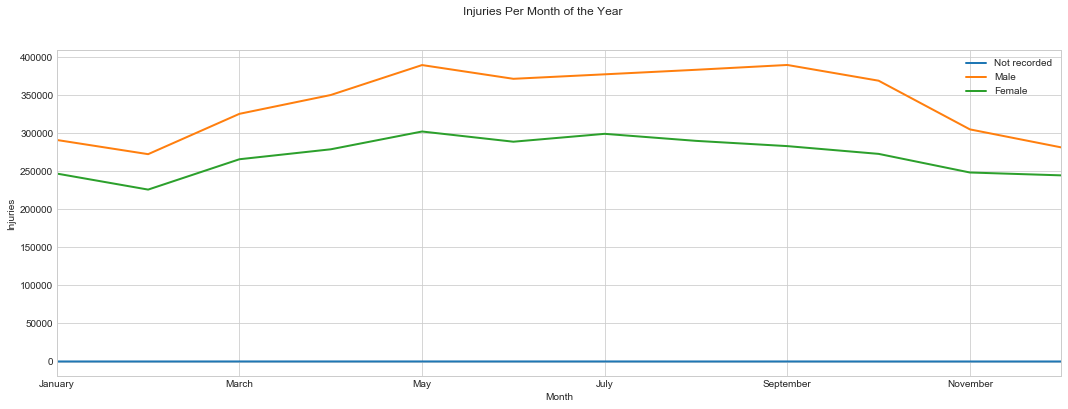

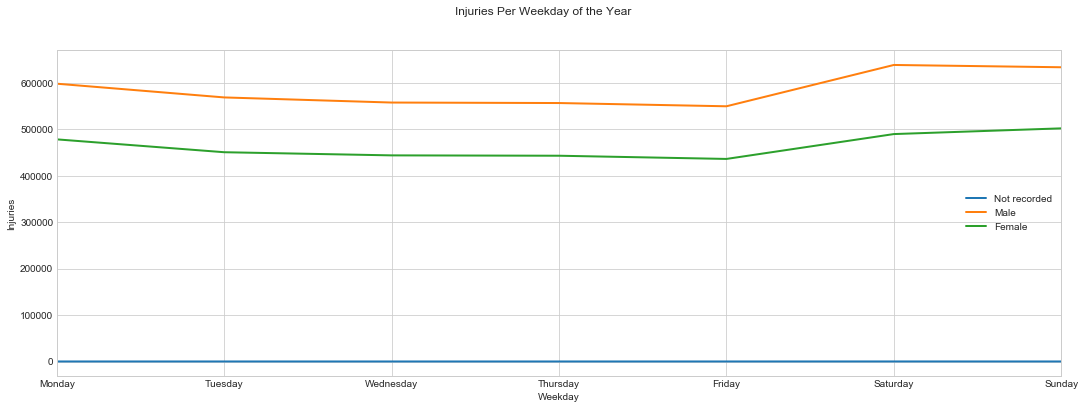

In [ ]:
if True == Includes.TimeBasedGraphs:
    stat_name = 'Sex'
    date_name = 'Treatment_Date'

    TimeBasedGraphs(dfNeiss, Neiss.getColumnDictionary(stat_name), date_name, stat_name).show()


## Functions/Classes used for the python correlations and pearson chi squared correlations

In [ ]:
def getHighCorrelations(df, dfCategoricalCorrMatrix, minValue):
    '''
    For each column in the dataframe determine which rows equal or exceed the minimum value
    
    Args:
        df (pd.DataFrame):    The original dataframe
        dfCategoricalCorrMatrix  (list of (row_name, col_name) tuples): The categorical matrix
        minValue (int):  The value the row/column cell must equal or exceed

    Returns:
      A list of tuples containing (row, column) where the value equalled or exceeded the minimum value
    '''
    high_correlations = []
    for yIndex, y in enumerate(dfCategoricalCorrMatrix.index):
        for xIndex, x in enumerate(dfCategoricalCorrMatrix.columns):
            #if xIndex >= yIndex:
            #    break

            if (x != y) and (dfCategoricalCorrMatrix[y][x] > minValue):
                Y = y
                X = x
                if len(df[X].unique()) > len(df[Y].unique()):
                    # Keep the smallest item on the X axis
                    Y, X = X, Y

                if (Y, X) not in high_correlations:
                    high_correlations.insert(-1, (Y, X))
    high_correlations.sort()
    return high_correlations

In [ ]:
class UserSelectableSwarmScatterPlots():
    def __init__(self, high_correlations, code_id_translator):
        self.button = widgets.Button(description="Click Me!")
        self.output = widgets.Output()
        self.high_correlations = high_correlations
        self.code_id_translator = code_id_translator

    def show(self):
        button = widgets.Button(description="Click Me!")
        output = widgets.Output()

        #print(self.high_correlations.values)
        select = self.high_correlations[0]
        #print(select)
        lCorrelations = ['{}, {}'.format(y, x) for y, x in self.high_correlations]
        correlationDropDownSel = widgets.Dropdown(
            options=lCorrelations,
            value=lCorrelations[0],
            description='correlations',
            disabled=False,
        )

        typeDropDownSel = widgets.Dropdown(
            options=['swarm', 'scatter'],
            value='swarm',
            description='plot_type',
            disabled=False,
        )

        wHBox = widgets.HBox([correlationDropDownSel, typeDropDownSel])
        wVBox = widgets.VBox([wHBox, button, output])

        display(wVBox)

        def on_button_clicked(b):
            with output:
                sel = correlationDropDownSel.value
                (xSel, ySel) = [x.strip() for x in sel.split(',')]
                print('-{}-, -{}-'.format(xSel, ySel))

                correlations(self.code_id_translator, xSel, ySel, typeDropDownSel.value)

                #sns.pairplot(dfSel, hue=xSel)

        button.on_click(on_button_clicked)

In [ ]:
class CategoricalMatrixHeatMap:
    def __init__(self, title, dfCategoricalMatrix):
        self.title = title
        self.dfCategoricalMatrix = dfCategoricalMatrix

    def show(self):
        fig, ax = plt.subplots(figsize=(10, 10))

        g = sns.heatmap(self.dfCategoricalMatrix, annot=True, linewidths=0.4, ax=ax)
        g.set_title(self.title)

        # Fix the top and bottom margins of the heatmap
        bottom_y, top_y = plt.ylim() 
        bottom_y += 0.5 
        top_y -= 0.5 
        plt.ylim(bottom_y, top_y)
        plt.show()

## Python Corr - dataframe subset used

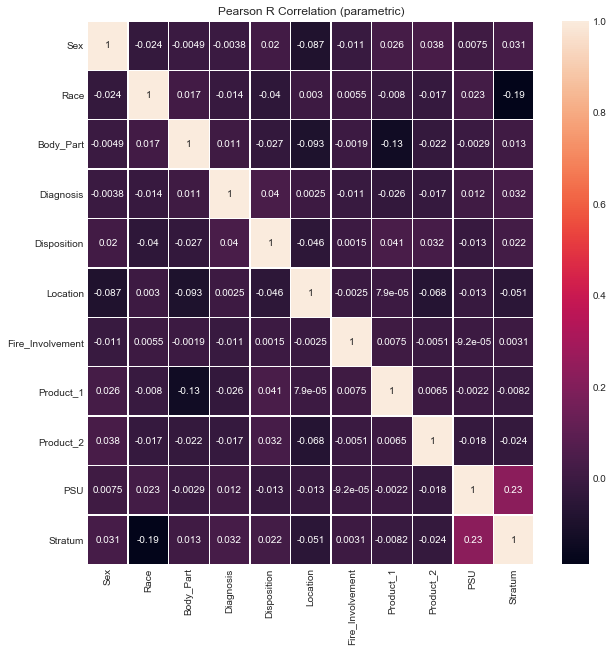

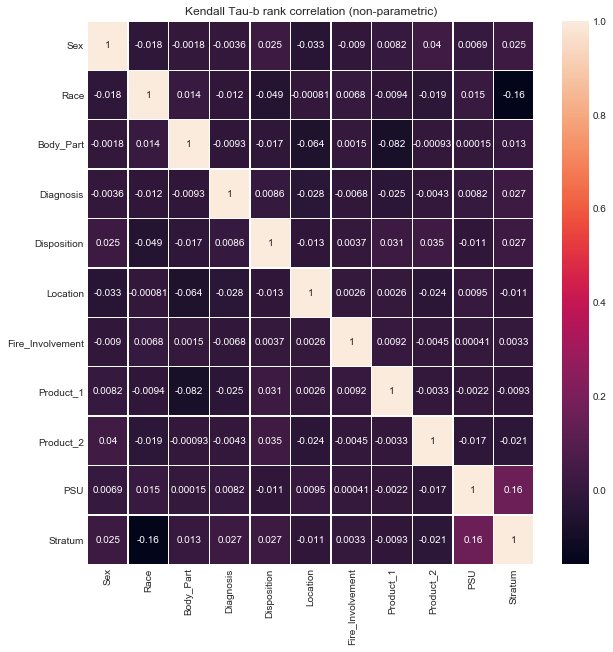

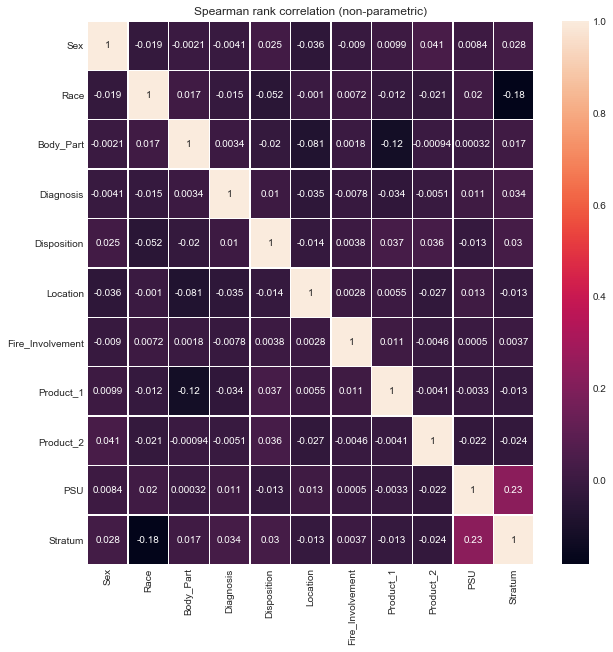

In [ ]:
if True == Includes.PythonCorr:
    methods = {
        'pearson' : 'Pearson R Correlation (parametric)',  # not good for categorical data
            # For pearson:
            # both variables should be normally distributed
            # There should be no significant outliers
            # Each variable should be continuous
            # The two variables have a linear relationship
            # The observations are paired observations.
            # Should support homoscedascity.  Homoscedascity simply refers to ‘equal variances’.
        'kendall' : 'Kendall Tau-b rank correlation (non-parametric)',
            # The variables are measured on an ordinal or continuous scale.
            # Desirable if your data appears to follow a monotonic relationship.
        'spearman' : 'Spearman rank correlation (non-parametric)'
            # Does not assume that both datasets are normally distributed
        }

    dfCategoricalMatrices = {}
    for key in methods.keys():
        dfCategoricalMatrices[key] = neissSubset.getDataframe().corr(method = key)
        heatMap = CategoricalMatrixHeatMap(methods[key], dfCategoricalMatrices[key])
        heatMap.show()


In [ ]:
#if True == Includes.PythonCorr:
#    for key in dfCategoricalMatrices.keys():
#        print('{}:\n{}'.format(key, dfCategoricalMatrices))
#        print()

In [ ]:
if True == Includes.PythonCorr:
    highCorrelationsPythonCorr = getHighCorrelations(
        neissSubset.getDataframe(),
        dfCategoricalMatrices['spearman'],
        0.1)

In [ ]:
#if True == Includes.PythonCorr:
#    for n in highCorrelationsPythonCorr:
#        print(n)

In [ ]:
if True == Includes.PythonCorr:
    plots = UserSelectableSwarmScatterPlots(highCorrelationsPythonCorr, neissSubset.getCodeIdTranslator())
    plots.show()


## PearsonChiSquared - dataframe subset used

https://machinelearningmastery.com/chi-squared-test-for-machine-learning/

'The Pearson’s chi-squared statistical hypothesis is an example of a test for independence between categorical variables.'

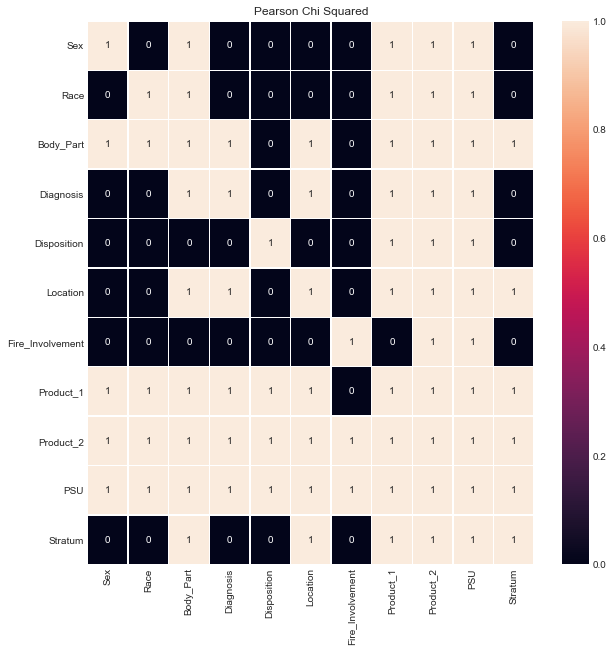

In [ ]:
if True == Includes.PearsonChiSquared:
    pearsonChiSquared = PearsonChiSquared(neissSubset.getDataframe())
    dfPersonChiSquaredCategoricalCorrMatrix = pearsonChiSquared.getCorrMatrixDataframe(neissSubset.getCategories())
    #print(dfCategoricalCorrMatrix.head())

    heatMap = CategoricalMatrixHeatMap('Pearson Chi Squared', dfPersonChiSquaredCategoricalCorrMatrix)
    heatMap.show() 

In [ ]:
if True == Includes.PearsonChiSquared:
    highCorrelationsPearsonChiSquared = getHighCorrelations(
        neissSubset.getDataframe(),
        dfPersonChiSquaredCategoricalCorrMatrix,
        0.95)

In [ ]:
#if True == Includes.PearsonChiSquared:
#    for n in highCorrelationsPearsonChiSquared:
#        print(n)

In [ ]:
if True == Includes.PearsonChiSquared:
    plots = UserSelectableSwarmScatterPlots(highCorrelationsPearsonChiSquared, neissSubset.getCodeIdTranslator())
    plots.show()

## Linear regression (using chi2) - dataframe subset used

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

- f_classif:  ANOVA F-value between label/feature for classification tasks.

- mutual_info_classif: Mutual information for a discrete target.

- chi2:  Chi-squared stats of non-negative features for classification tasks.

- f_regression:  F-value between label/feature for regression tasks.

- mutual_info_regression:  Mutual information for a continuous target.
    
- SelectPercentile:  Select features based on percentile of the highest scores.

- SelectFpr:  Select features based on a false positive rate test.

- SelectFdr:  Select features based on an estimated false discovery rate.

- SelectFwe:  Select features based on family-wise error rate.

- GenericUnivariateSelect:  Univariate feature selector with configurable mode.


In [ ]:
if True == Includes.LinearRegressionChi2:
    class WorkingLinearRegressionChi2():
        def __init__(self, outputFeature, categories, dfIdToCode):
            self.outputFeature = outputFeature
            self.categories = categories.copy()
            self.dfKBest = dfIdToCode.copy()
        
            self.categories.remove(self.outputFeature)

            self.y = self.dfKBest[self.outputFeature]
            self.selector = SelectKBest(chi2, k=3)
            self.selector.fit(self.dfKBest[self.categories].values, self.y)
            self.selector.get_support()

            self.selected_columns = np.asarray(self.categories)[self.selector.get_support()]
            self.X = self.dfKBest[self.selected_columns]
    
            
        def plot_scatter(X,Y,R=None):
            plt.scatter(X, Y, s=32, marker='o', facecolors='none', edgecolors='k')
            if R is not None:
                plt.scatter(X, R, color='red', linewidth=0.5)
            plt.show()  

        def showShape(self):
            print('X.shape={}'.format(self.X.shape))
            print()

        def showSelectedColumns(self):
            print('selected_columns={}'.format(self.selected_columns))
            print()

        def showSelectorScores(self):
            print('selector.scores_={}'.format(self.selector.scores_))
            print()

        def showSelectorSupport(self):
            print('selector.get_support()={}'.format(self.selector.get_support()))
            print()

        def showPlots(self):
            for category in self.X:
                print('x=', category)
                x = np.asarray(self.dfKBest[category]).reshape(-1, 1)
                regressor = LinearRegression(normalize=True).fit(x, self.y)
                y_pred    = regressor.predict(x)
                WorkingLinearRegressionChi2.plot_scatter(x, self.y, y_pred)
                print("R-squared score: {:.4f}".format(r2_score(self.y, y_pred)))
                print()
                print()


In [ ]:
if True == Includes.LinearRegressionChi2:
    linearRegressionChi2 = WorkingLinearRegressionChi2(
        output_choice, neissSubset.getCategories(), neissSubset.getIdToCodeDataframe())

In [ ]:
if True == Includes.LinearRegressionChi2:
    linearRegressionChi2.showShape()
    linearRegressionChi2.showSelectedColumns()
    linearRegressionChi2.showSelectorScores()
    linearRegressionChi2.showSelectorSupport()

X.shape=(100000, 3)

selected_columns=['Body_Part' 'Product_1' 'Product_2']

selector.scores_=[9.13363054e+01 8.03844850e+01 3.78737327e+04 1.92374659e+03
 8.38198228e+03 3.52382156e-01 2.30573978e+05 5.08650144e+05
 6.74761874e+03 6.02753841e+02]

selector.get_support()=[False False  True False False False  True  True False False]



x= Body_Part


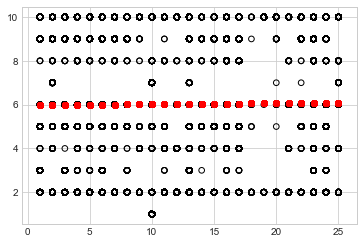

R-squared score: 0.0001


x= Product_1


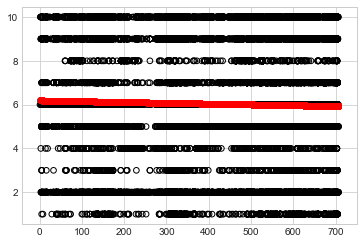

R-squared score: 0.0007


x= Product_2


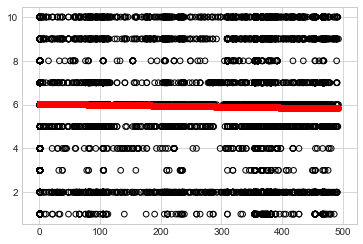

R-squared score: 0.0003




In [ ]:
if True == Includes.LinearRegressionChi2:
    linearRegressionChi2.showPlots()

## Logistic Regression

In [ ]:
if True == Includes.LogisticRegression:
    class WorkingLogisticRegression():
        '''
        Based loosly on:  https://acadgild.com/blog/logistic-regression-multiclass-classification
        '''
        def __init__(self, outputFeature, categories, dfIdToCode, codeIdTranslator):
            self.outputFeature = outputFeature
            self.categories = categories.copy()
            self.df = dfIdToCode.copy()
            self.codeIdTranslator = codeIdTranslator
        
            self.categories.remove(self.outputFeature)
    
            self.inputs = self.df[self.categories]
            self.output = self.df[self.outputFeature]
            
            self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(
                self.inputs, self.output, test_size=1/7.0, random_state=122)

            # Standardize the data
            scaler = StandardScaler()
            
            # Fit on training set only.
            scaler.fit(self.x_train)

            # Apply transform to both the training set and the test set.
            self.x_train = scaler.transform(self.x_train)
            self.x_test = scaler.transform(self.x_test)

            # Fit the model
            # For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss.
            #self.model = LogisticRegression(solver = 'lbfgs', multi_class='multinomial', max_iter=1000)
            self.model = LogisticRegression(solver = 'newton-cg', multi_class='multinomial', max_iter=1000)
            self.model.fit(self.x_train, self.y_train)

            # Validate the fitting
            # use the model to make predictions with the test data
            self.y_pred = self.model.predict(self.x_test)

            self.probs = self.model.predict_proba(self.x_test)

            # how did our model perform?
            self.count_misclassified = (self.y_test != self.y_pred).sum()
            self.accuracy = metrics.accuracy_score(self.y_test, self.y_pred)

            self.confusion_matrix = metrics.confusion_matrix(self.y_test, self.y_pred)

            # Create predicted versus actual dataframe
            target_names = self.output.unique()

            target_dict = column_dictionary[self.outputFeature]

            dfTest = pd.DataFrame(self.y_test, columns=[self.outputFeature])
            self.codeIdTranslator._transform(dfTest, 'idToCode', self.outputFeature)
            y_test = [target_dict[x] for x in dfTest[self.outputFeature]]
            #print('y_test={}'.format( np.sort(np.unique(y_test)) ))
            
            dfPred = pd.DataFrame(self.y_pred, columns=[self.outputFeature])
            self.codeIdTranslator._transform(dfPred, 'idToCode', self.outputFeature)
            y_pred = [target_dict[x] for x in dfPred[self.outputFeature]]
            #print('y_pred={}'.format( np.sort(np.unique(y_pred)) ))

            dfTargetNames = pd.DataFrame(target_names, columns=[self.outputFeature])
            self.codeIdTranslator._transform(dfTargetNames, 'idToCode', self.outputFeature)
            target_names =  [target_dict[x] for x in dfTargetNames[self.outputFeature]]
            #print('target_names={}'.format( np.sort(np.unique(target_names)) ))

            self.dfPredictedVersusActual = pd.DataFrame(self.probs, columns=target_names).round(4)
            self.dfPredictedVersusActual.insert(0, 'target_class',    y_test)
            self.dfPredictedVersusActual.insert(1, 'predicted_class', y_pred)
            
        def showAccuracy(self):
            print('Accuracy: {:.2f}'.format(self.accuracy))

        def showMissclassifiedSamples(self):
            print('Misclassified samples: {} out of {}'.format(self.count_misclassified, len(self.y_test)))

        def showConfusionMatrix(self):
            print('Confusion Matrix:\n{}'.format(self.confusion_matrix))

        def getPredictedVersusActualDataframe(self):
            #state = self.codeIdTranslator.getState()
            return self.dfPredictedVersusActual



In [ ]:
if True == Includes.LogisticRegression:
    logisticRegression = WorkingLogisticRegression(
        output_choice,
        neissSubset.getCategories(),
        neissSubset.getIdToCodeDataframe(),    # neissSubset.getIdToCodeDataframe()[0:1500]
        neissSubset.getCodeIdTranslator())


In [ ]:
if True == Includes.LogisticRegression:
    logisticRegression.showAccuracy()
    logisticRegression.showMissclassifiedSamples()
    #logisticRegression.showConfusionMatrix()
    dfPredictedVersusActual = logisticRegression.getPredictedVersusActualDataframe()
    display(dfPredictedVersusActual)

Accuracy: 0.30
Misclassified samples: 10057 out of 14286


,target_class,predicted_class,Fracture,Strain or Sprain,Other/Not Stated,"Contusions, Abrasions",Internal organ injury,Laceration,Foreign body,Dislocation,Puncture,Concussions
0,Fracture,Fracture,0.0126,0.1106,0.0077,0.0165,0.3427,0.0950,0.1134,0.0075,0.0399,0.2541
1,Strain or Sprain,"Contusions, Abrasions",0.0099,0.2504,0.0093,0.0175,0.1512,0.1468,0.0623,0.0121,0.2169,0.1236
2,"Contusions, Abrasions",Strain or Sprain,0.0418,0.1620,0.0310,0.0029,0.2023,0.1255,0.0707,0.0024,0.2792,0.0822
3,Other/Not Stated,Fracture,0.0250,0.0750,0.0298,0.0038,0.3815,0.0519,0.2319,0.0021,0.0229,0.1761
4,Other/Not Stated,Strain or Sprain,0.0154,0.2415,0.0388,0.0031,0.1684,0.0773,0.0791,0.0029,0.2615,0.1120
...,...,...,...,...,...,...,...,...,...,...,...,...
14281,Fracture,Fracture,0.0212,0.0646,0.0064,0.0282,0.3315,0.1470,0.1597,0.0077,0.0148,0.2188
14282,Fracture,Strain or Sprain,0.0305,0.1807,0.0337,0.0028,0.1784,0.1162,0.0484,0.0030,0.3123,0.0939
14283,Strain or Sprain,"Contusions, Abrasions",0.0173,0.2317,0.0196,0.0077,0.1869,0.1153,0.1018,0.0037,0.2206,0.0955
14284,Internal organ injury,Fracture,0.0365,0.1591,0.0171,0.0096,0.2055,0.2015,0.1011,0.0048,0.1700,0.0947


## Gaussian Naive Bayes (GaussianNB) - dataframe subset used


Can perform online updates to model parameters via partial_fit method. 

For details on algorithm used to update feature means and variance online, 

see Stanford CS tech report STAN-CS-79-773 by Chan, Golub, and LeVeque:


http://i.stanford.edu/pub/cstr/reports/cs/tr/79/773/CS-TR-79-773.pdf


In [ ]:
if True == Includes.GaussianNB:
    class WorkingGaussianNB():
        def __init__(self, outputFeature, categories, dfIdToCode, verbose=False):
            self.outputFeature = outputFeature
            self.categories = categories.copy()
            self.df = dfIdToCode.copy()
    
            self.categories.remove(outputFeature)

            # Build the Label encoder
            self.le = {}
            for col in self.df.columns:
                self.le[col] = preprocessing.LabelEncoder()
                self.le[col].fit(self.df[col].unique())

                if True == verbose:
                    print('{0:12s} => {1}'.format(col, self.le[col].classes_))


            # Train classifier
            for category in self.categories:
                print(category, end=' - ')
                inputFeature = [category]

                gnb = GaussianNB()
                gnb.fit(
                    self.df[inputFeature].values,
                    self.df[outputFeature]
                )

                y_pred = gnb.predict(self.df[inputFeature])

                # Print results
                print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
                      .format(
                          self.df.shape[0],
                          (self.df[self.outputFeature] != y_pred).sum(),
                          100*(1-(self.df[self.outputFeature] != y_pred).sum()/self.df.shape[0])
                ), end=' ')

                self.dfPredicted = pd.DataFrame()
                try:
                    self.dfPredicted = pd.DataFrame(
                        {'predicted': self.le[self.outputFeature].inverse_transform(y_pred),
                         'actual':    self.df[self.outputFeature]})
                except:
                    pass

                self.confusion_matrix = metrics.confusion_matrix(y_pred, self.df[self.outputFeature])
                print('complete')

        def showPredicted(self):
            print('dfPredicted:\n{}'.format(self.dfPredicted))

        def showConfusionMatrix(self):
            print('confusion_matrix:\n{}'.format(self.confusion_matrix))

        def compute(self, show_predicted_versus_actual=True, show_confusion_matrices=True):
            # Drop categories with low scores
            categories = self.categories.copy()
            categories.remove('Sex')
            categories.remove('Disposition')
            categories.remove('Location')
            categories.remove('Product_2')
            categories.remove('Stratum')

            df = self.df.copy()
            df.drop(['Sex', 'Disposition', 'Location', 'Product_2', 'Stratum'], axis=1, inplace=True)

            predictedOutputs = {}
            for category in categories:
                print('{}:  '.format(category), end=' ')

                inputFeature = [category]

                # Train classifier
                gnb = GaussianNB()
                gnb.fit(
                    df[inputFeature].values,
                    df[self.outputFeature]
                )

                y_pred = gnb.predict(self.df[inputFeature])
                #print(y_pred)

                # Print results
                print("Number of mislabeled points out of a total {} points : {}, performance {:05.2f}%"
                      .format(
                          df.shape[0],
                          (df[self.outputFeature] != y_pred).sum(),
                          100*(1-(df[self.outputFeature] != y_pred).sum()/df.shape[0])
                ))
                
                dfPredicted = pd.DataFrame(
                    {'predicted': self.le[self.outputFeature].inverse_transform(y_pred),
                     'actual':    df[self.outputFeature]})

                if True == show_predicted_versus_actual:
                    print(dfPredicted)

                predictedOutputs[category] = y_pred

                if True == show_confusion_matrices:
                    print('\nConfusion matrices')
                    for catecory in predictedOutputs:
                            print("----------------------------")
                            print('{}:'.format(category))
                            print()

                            # df[self.outputFeature] has 29 unique values.  That is why there are 29 columns
                            print(metrics.confusion_matrix(predictedOutputs[catecory], df[self.outputFeature]))
                            print()


In [ ]:
if True == Includes.GaussianNB:
    gaussianNB = WorkingGaussianNB(
        output_choice, neissSubset.getCategories(), neissSubset.getIdToCodeDataframe())

Sex - Number of mislabeled points out of a total 100000 points : 77102, performance 22.90% complete
Race - Number of mislabeled points out of a total 100000 points : 77761, performance 22.24% complete
Body_Part - Number of mislabeled points out of a total 100000 points : 77000, performance 23.00% complete
Disposition - Number of mislabeled points out of a total 100000 points : 80734, performance 19.27% complete
Location - Number of mislabeled points out of a total 100000 points : 74801, performance 25.20% complete
Fire_Involvement - Number of mislabeled points out of a total 100000 points : 98178, performance 01.82% complete
Product_1 - Number of mislabeled points out of a total 100000 points : 78443, performance 21.56% complete
Product_2 - Number of mislabeled points out of a total 100000 points : 80978, performance 19.02% complete
PSU - Number of mislabeled points out of a total 100000 points : 77684, performance 22.32% complete
Stratum - Number of mislabeled points out of a total 10

In [ ]:
#if True == Includes.GaussianNB:
#    gaussianNB.showPredicted()
#    gaussianNB.showConfusionMatrix()


In [ ]:
if True == Includes.GaussianNB:
    gaussianNB.compute(show_predicted_versus_actual=False, show_confusion_matrices=False)


Race:   Number of mislabeled points out of a total 100000 points : 77761, performance 22.24%
Body_Part:   Number of mislabeled points out of a total 100000 points : 77000, performance 23.00%
Fire_Involvement:   Number of mislabeled points out of a total 100000 points : 98178, performance 01.82%
Product_1:   Number of mislabeled points out of a total 100000 points : 78443, performance 21.56%
PSU:   Number of mislabeled points out of a total 100000 points : 77684, performance 22.32%


## Decision Tree - dataframe subset used

In [ ]:
def replaceValueWithStringInColumn(column_name, replace_value, with_string):
    dfDecisionTree[column_name] = [
            with_string if str(x) == '{}'.format(replace_value) else x 
            for x in dfDecisionTree[column_name]]  # Replace zeros in col='disposition' with 'Unknown'


In [ ]:
def checkForNumericValueInColumn(columnName):
    for index, value in enumerate(dfDecisionTree[columnName]):
        if type(value) == int:
            if 'Treatment_Date' in dfDecisionTree.columns:
                print('{}: Found int={} at {} - {}'.format(
                    columnName, value, index, dfDecisionTree['Treatment_Date'].iloc[index]))
            else:
                print('{}: Found int={} at {}'.format(columnName, value, index))
                


In [ ]:
def createOnHotEncodedDataframe(df):
    '''
    Take columns that are objects and turn them into multiple one-hot columns.

    Args:
        df    (pd.DataFrame):  The dataframe to convert to a one-hot dataframe

    Returns:
        dfOneHot (pd.DataFrame):  A dataframe with the original objects replaced with one-hot versions.


    Example dataframe:

        Cost(dollars)  Item
        2              'Baseball'
        5              'Baseball Glove'
        7              'Helmet'

    Will become a dataframe similar to:

        Cost(dollars)  ('Item', 'Baseball')    ('Item', 'Baseball Glove')  ('Item', 'Helmet)
        2              1                       0                           0
        5              0                       1                           0
        7              0                       0                           1

    By making a tuple for the column header it is easy to determine the variable that the one-hot
    column represents.
    '''
    dfOneHot = df.copy()

    updateFreq = 100
    print('Dots are printed every {} translations'.format(updateFreq))

    for col in df.columns:
        if df[col].dtype == object:
            print('Transforming {:20s}'.format(col), end='\t')

            unique = pd.unique(df[col].sort_values(ascending=True))
            nUnique = len(unique)
            print('nUnique={}'.format(nUnique), end='\t')

            updateIndex = updateFreq
            updateNext = updateFreq

            for index, value in enumerate(unique):
                if index == updateIndex:
                    updateIndex += updateFreq
                    updateNext += updateFreq
                    print('.', end='')
                    
                dfOneHot[(col, value)] = (dfOneHot[col] == value).astype(int)
            dfOneHot.drop(columns=[col], inplace=True)
            print('\tcomplete')
    return dfOneHot


In [ ]:
if True == Includes.DecisionTree:
    dfNeissDecisionTree = neiss.getDataFrame().copy()

    # Remove columns containing NaN or columns where the number of unique items is greater than 
    toBeDropped = []
    for col in dfNeissDecisionTree.columns:
        if dfNeissDecisionTree[col].isnull().values.any():
            toBeDropped.append(col)

    # Also remove the case number and the narrative
    toBeDropped.extend(['CPSC_Case_Number', 'Narrative_1'])

    # The following dates (1999 ... 2013) contain codes that do not match the column_codes table.
    dfNeissDecisionTree = dfNeissDecisionTree[
        ~dfNeissDecisionTree['Treatment_Date'].dt.year.isin(list(range(1999, 2013)))]

    #toBeDropped.extend(['Treatment_Date'])
    dfNeissDecisionTree.drop(toBeDropped, axis=1, inplace=True)

    # Remove values from dates (2014 ... 2018) that do not have column codes for them
    dfNeissDecisionTree = dfNeissDecisionTree[~dfNeissDecisionTree['Product_1'].isin([1841, 1903])]
    dfNeissDecisionTree = dfNeissDecisionTree[~dfNeissDecisionTree['Product_2'].isin([1841, 1903])]

    dfNeissDecisionTree['mDate'] = mdates.date2num(dfNeissDecisionTree['Treatment_Date']) 
    dfNeissDecisionTree.drop(['Treatment_Date'], axis=1, inplace=True)

    #dfDecisionTree = Neiss.translateCodes(dfNeissDecisionTree[0 : len(dfNeissDecisionTree) // 4])  # Use 1/4 the data
    #dfDecisionTree = Neiss.translateCodes(dfNeissDecisionTree[0 : len(dfNeissDecisionTree) // 2])  # Use 1/2 the data
    dfDecisionTree = Neiss.translateCodes(dfNeissDecisionTree)


    replaceValueWithStringInColumn('Product_1', 0, 'Zero') # Keep the zero.
    replaceValueWithStringInColumn('Product_2', 0, 'Zero') # Especially for Product_2.
    replaceValueWithStringInColumn('Fire_Involvement', 4, 'InvalidCode')


    for col in dfDecisionTree.columns:
        print('{:20s}\tnunique={}\tnum_nulls={}\ttype={}'.format(
            col,
            dfDecisionTree[col].nunique(),
            dfDecisionTree[col].isnull().sum(),
            dfDecisionTree[col].dtype))

    print('Done')

Age                 	nunique=135	num_nulls=0	type=int64
Sex                 	nunique=3	num_nulls=0	type=object
Body_Part           	nunique=26	num_nulls=0	type=object
Diagnosis           	nunique=30	num_nulls=0	type=object
Disposition         	nunique=7	num_nulls=0	type=object
Location            	nunique=9	num_nulls=0	type=object
Fire_Involvement    	nunique=4	num_nulls=0	type=object
Product_1           	nunique=793	num_nulls=0	type=object
Product_2           	nunique=759	num_nulls=0	type=object
Stratum             	nunique=5	num_nulls=0	type=object
PSU                 	nunique=94	num_nulls=0	type=int64
Weight              	nunique=88	num_nulls=0	type=float64
mDate               	nunique=2191	num_nulls=0	type=float64
Done


In [ ]:
if True == Includes.DecisionTree:
    #checkForNumericValueInColumn('Disposition')
    checkForNumericValueInColumn('Fire_Involvement')
    checkForNumericValueInColumn('Product_1')
    checkForNumericValueInColumn('Product_2')

    print('Done')

Done


In [ ]:
if True == Includes.DecisionTree:
    dfOneHot = createOnHotEncodedDataframe(dfDecisionTree)

    yLabels = []
    for col in dfOneHot.columns:
        if col[0] == output_choice:
            yLabels.append(col)

    xLabels = [value for value in dfOneHot.columns if value not in yLabels]

    x = dfOneHot[xLabels]
    y = dfOneHot[yLabels]



Dots are printed every 100 translations
Transforming Sex                 	nUnique=3		complete
Transforming Body_Part           	nUnique=26		complete
Transforming Diagnosis           	nUnique=30		complete
Transforming Disposition         	nUnique=7		complete
Transforming Location            	nUnique=9		complete
Transforming Fire_Involvement    	nUnique=4		complete
Transforming Product_1           	nUnique=793	...

In [ ]:
if True == Includes.DecisionTree:
    clfDecisionTree = DecisionTreeClassifier() # gini is the default criterion
    #clfDecisionTree = DecisionTreeClassifier(criterion="entropy")
    clfDecisionTreeFit = clfDecisionTree.fit(x, y)
    print(clfDecisionTreeFit)


- ***** 
- Full data model accuracy
- ***** 

In [ ]:
if True == Includes.DecisionTree:
    y_pred = clfDecisionTreeFit.predict(x)
    y_pred

    # Model accuracy
    accuracy = metrics.accuracy_score(y, y_pred)

In [ ]:
if True == Includes.DecisionTree:
    print(accuracy)

In [ ]:
# This code generates the following error for some reason:
#    Error: neiss_2013_2018: syntax error in line 743 near ','

#if True == Includes.DecisionTree:
    #dot_data=export_graphviz(clfDecisionTreeFit, out_file=None, 
    #                     feature_names=xLabels,  # inputs
    #                     class_names=yLabels, # outputs 
    #                     filled=True, rounded=True,   
    #                     special_characters=True)  
    #graph = graphviz.Source(dot_data) 
    #graph.render("neiss_2013_2018")

In [ ]:
#if True == Includes.DecisionTree:
#    !open neiss_2013_2018.pdf

- ***** 
- Now with 70% training set, 30% testing set
- ***** 

In [ ]:
if True == Includes.DecisionTree:
    bu_id = 7286

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=bu_id)

    clfGini = DecisionTreeClassifier()
    clfGiniFit = clfGini.fit(X_train, y_train)
    print(clfGiniFit)

    y_pred = clfGiniFit.predict(X_test)
    # print(y_pred)

    # Model accuracy
    accuracy = metrics.accuracy_score(y_test, y_pred)
    print(accuracy)
